In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Reshape, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ===========================
# 1️⃣ Préparer Fashion-MNIST
# ===========================
(X_train, _), (X_test, _) = fashion_mnist.load_data()

# Images pour VGG16 / ResNet50
X_train_resized = np.array([cv2.resize(img, (32,32)) for img in X_train])
X_test_resized  = np.array([cv2.resize(img, (32,32)) for img in X_test])
X_train_resized = np.expand_dims(X_train_resized, -1)
X_test_resized  = np.expand_dims(X_test_resized, -1)
X_train_rgb = np.concatenate([X_train_resized]*3, axis=-1)
X_test_rgb  = np.concatenate([X_test_resized]*3, axis=-1)
X_train_rgb = X_train_rgb.astype("float32")/255.
X_test_rgb  = X_test_rgb.astype("float32")/255.

# Images pour Contractive Autoencoder
X_train_scaled = X_train.astype('float32')/255.
X_test_scaled  = X_test.astype('float32')/255.
X_train_scaled = X_train_scaled.reshape(-1,28*28)
X_test_scaled  = X_test_scaled.reshape(-1,28*28)

print("Forme VGG/ResNet:", X_train_rgb.shape, "| Forme CAE:", X_train_scaled.shape)

# ===========================
# 2️⃣ Décodeur commun
# ===========================
def build_decoder(latent_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4*4*128, activation='relu')(decoder_input)
    x = Reshape((4,4,128))(x)
    for filters in [128,64,32]:
        x = Conv2DTranspose(filters,(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    decoded = Conv2DTranspose(3,(3,3), activation='sigmoid', padding='same')(x)
    return Model(decoder_input, decoded)

# ===========================
# 3️⃣ Autoencodeurs VGG16 / ResNet50
# ===========================
def build_autoencoder(base_model_class, name):
    base_model = base_model_class(input_shape=(32,32,3), include_top=False, weights='imagenet')
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    encoder = Model(base_model.input, x, name=f"{name}_encoder")
    latent_dim = encoder.output_shape[-1]
    decoder = build_decoder(latent_dim)
    input_img = Input(shape=(32,32,3))
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded, name=f"{name}_autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder

# ===========================
# 4️⃣ Contractive Autoencoder
# ===========================
input_dim = 28*28
latent_dim_cae = 64
lambda_c = 1e-3

input_img_cae = Input(shape=(input_dim,))
encoded_cae = Dense(latent_dim_cae, activation='relu')(input_img_cae)
decoded_cae = Dense(input_dim, activation='sigmoid')(encoded_cae)
autoencoder_cae = Model(input_img_cae, decoded_cae)

# Loss contractive
@tf.function
def contractive_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    # Gradient par rapport à l'entrée réelle
    W = autoencoder_cae.layers[1].kernel
    z = tf.matmul(y_true, W) + autoencoder_cae.layers[1].bias
    z = tf.nn.relu(z)
    jacobian = tf.reduce_sum(tf.square(W), axis=0)
    return mse_loss + lambda_c * tf.reduce_sum(jacobian)

autoencoder_cae.compile(optimizer='adam', loss=contractive_loss)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Forme VGG/ResNet: (60000, 32, 32, 3) | Forme CAE: (60000, 784)


In [2]:
# ===========================
# 5️⃣ Entraînement
# ===========================
results = {}

# CAE
print("\n=== Entraînement Contractive Autoencoder ===")
autoencoder_cae.fit(X_train_scaled, X_train_scaled, validation_split=0.1,
                    epochs=20, batch_size=128, verbose=1)
mse_cae = autoencoder_cae.evaluate(X_test_scaled, X_test_scaled, verbose=0)
results["CAE"] = {"autoencoder": autoencoder_cae, "encoder": Model(input_img_cae, encoded_cae),
                  "decoder": Model(encoded_cae, decoded_cae), "mse": mse_cae}


for model_class, name in [(VGG16,"VGG16"), (ResNet50,"ResNet50")]:
    print(f"\n=== Entraînement {name} ===")
    autoencoder, encoder, decoder = build_autoencoder(model_class, name)
    autoencoder.fit(X_train_rgb, X_train_rgb, validation_split=0.1,
                    epochs=20, batch_size=128, verbose=1)
    mse = autoencoder.evaluate(X_test_rgb, X_test_rgb, verbose=0)
    results[name] = {"autoencoder": autoencoder, "encoder": encoder, "decoder": decoder, "mse": mse}

# ===========================
# 6️⃣ Affichage MSE
# ===========================
print("\n=== MSE Comparatif ===")
for name in results:
    print(f"{name} : {results[name]['mse']:.6f}")




=== Entraînement Contractive Autoencoder ===
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1043 - val_loss: 0.0335
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0312 - val_loss: 0.0274
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0267 - val_loss: 0.0252
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0248 - val_loss: 0.0239
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0235 - val_loss: 0.0228
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0216 - val_loss: 0.0211
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 9/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 10/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 11/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0188
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


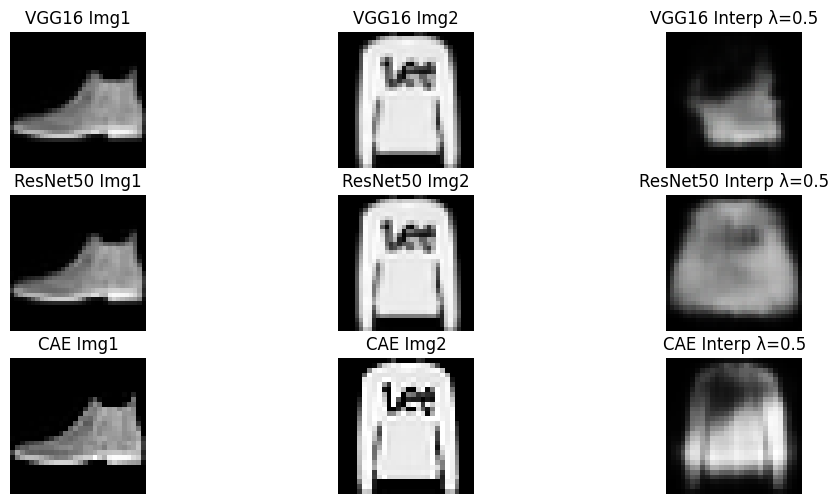

In [3]:
# ===========================
# 7️⃣ Interpolation linéaire entre deux images
# ===========================
img_idx1, img_idx2 = 0, 1
lambda_val = 0.5

plt.figure(figsize=(12,6))
for j, name in enumerate(["VGG16","ResNet50","CAE"]):
    encoder = results[name]["encoder"]
    decoder = results[name]["decoder"]

    if name == "CAE":
        latent1 = encoder.predict(X_test_scaled[img_idx1:img_idx1+1])
        latent2 = encoder.predict(X_test_scaled[img_idx2:img_idx2+1])
    else:
        latent1 = encoder.predict(X_test_rgb[img_idx1:img_idx1+1])
        latent2 = encoder.predict(X_test_rgb[img_idx2:img_idx2+1])

    latent_interp = (1-lambda_val)*latent1 + lambda_val*latent2
    img_interp = decoder.predict(latent_interp)

    # Affichage
    if name == "CAE":
        plt.subplot(3,3,j*3+1); plt.imshow(X_test_scaled[img_idx1].reshape(28,28), cmap='gray'); plt.title(f"{name} Img1"); plt.axis('off')
        plt.subplot(3,3,j*3+2); plt.imshow(X_test_scaled[img_idx2].reshape(28,28), cmap='gray'); plt.title(f"{name} Img2"); plt.axis('off')
        plt.subplot(3,3,j*3+3); plt.imshow(img_interp[0].reshape(28,28), cmap='gray'); plt.title(f"{name} Interp λ={lambda_val}"); plt.axis('off')
    else:
        plt.subplot(3,3,j*3+1); plt.imshow(X_test_rgb[img_idx1]); plt.title(f"{name} Img1"); plt.axis('off')
        plt.subplot(3,3,j*3+2); plt.imshow(X_test_rgb[img_idx2]); plt.title(f"{name} Img2"); plt.axis('off')
        plt.subplot(3,3,j*3+3); plt.imshow(img_interp[0]); plt.title(f"{name} Interp λ={lambda_val}"); plt.axis('off')
plt.show()